
Model Accuracy: 0.9235


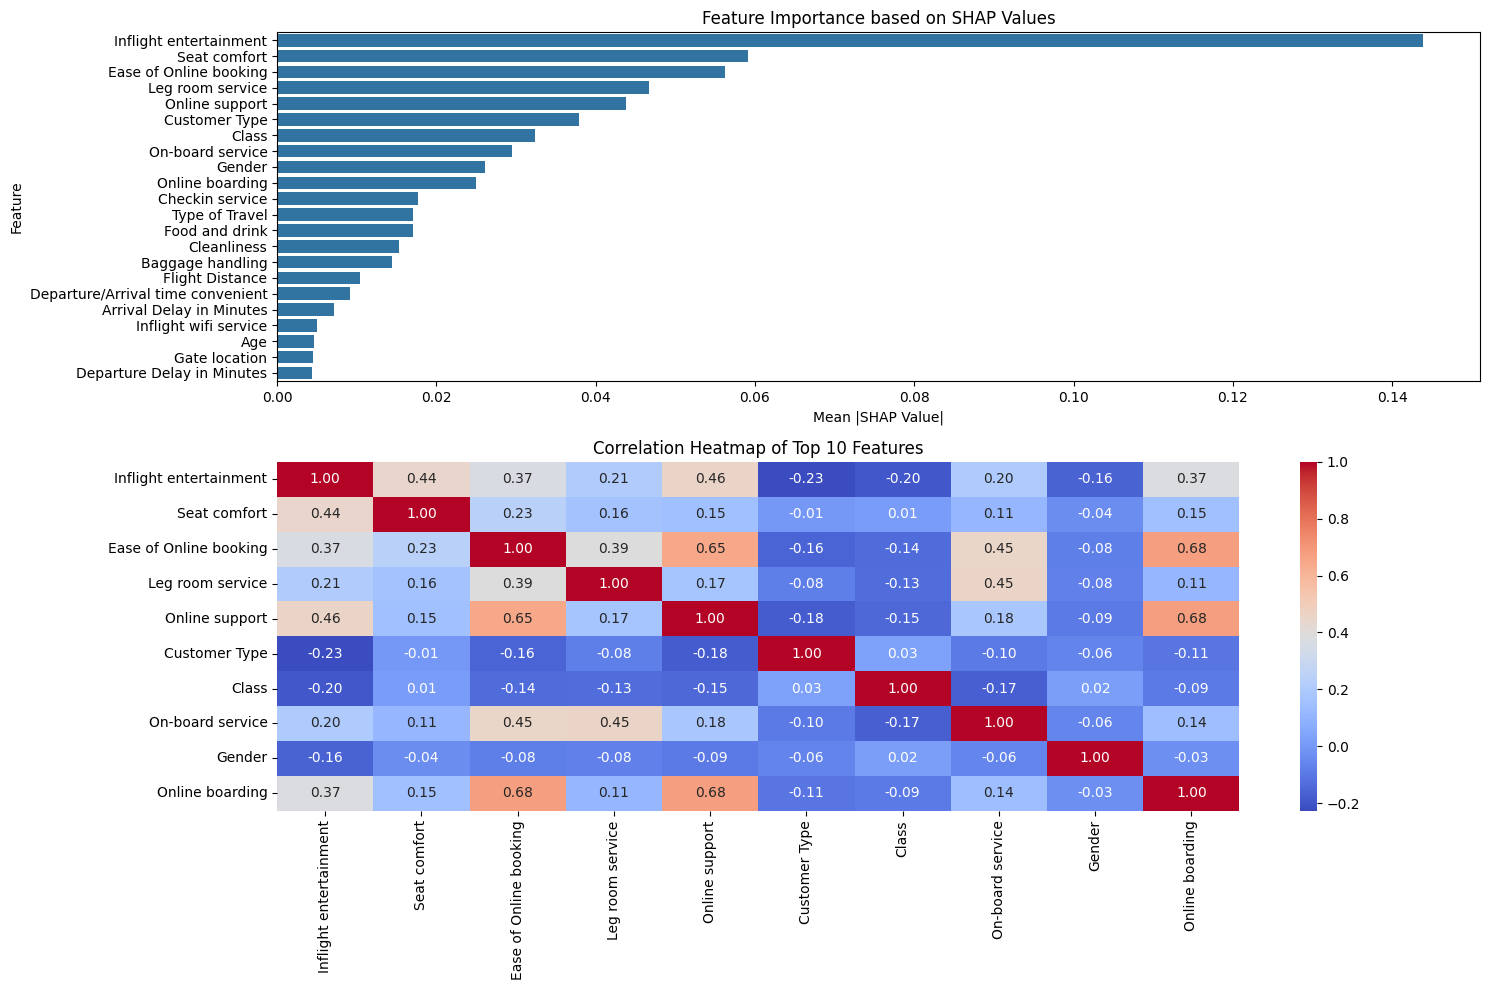


Top 10 Features Contributing to Customer Satisfaction:
------------------------------------------------------------
                   Feature  Contribution %
11  Inflight entertainment           22.92
6             Seat comfort            9.42
13  Ease of Online booking            8.96
15        Leg room service            7.44
12          Online support            6.99
1            Customer Type            6.03
4                    Class            5.16
14        On-board service            4.71
0                   Gender            4.16
19         Online boarding            3.97

Category-wise Contribution Analysis:
------------------------------------------------------------
            Category  Total Importance  Contribution %
3  Online Experience              0.13           27.66
1            Comfort              0.12           25.78
4      Customer Info              0.12           25.13
2           Services              0.08           16.77
0       Basic Flight              0.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Read the data
df = pd.read_csv('/content/Invistico_Airline.csv')

# Take a smaller sample for faster processing
df = df.sample(n=10000, random_state=42)

# Data preprocessing
categorical_cols = ['satisfaction', 'Gender', 'Customer Type', 'Type of Travel', 'Class']
le_dict = {}

# Efficient label encoding
for col in categorical_cols:
    le_dict[col] = LabelEncoder()
    df[col] = le_dict[col].fit_transform(df[col].astype(str))

# Fill missing values with median
df = df.fillna(df.median())

# Prepare features and target
feature_cols = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
                'Flight Distance', 'Seat comfort', 'Departure/Arrival time convenient',
                'Food and drink', 'Gate location', 'Inflight wifi service',
                'Inflight entertainment', 'Online support', 'Ease of Online booking',
                'On-board service', 'Leg room service', 'Baggage handling',
                'Checkin service', 'Cleanliness', 'Online boarding',
                'Departure Delay in Minutes', 'Arrival Delay in Minutes']

X = df[feature_cols]
y = df['satisfaction']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simpler Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f}")

# Calculate SHAP values on a smaller subset for efficiency
shap_sample_size = min(1000, len(X_test))
X_shap = X_test.iloc[:shap_sample_size]

# Initialize SHAP explainer and calculate values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_shap)

# If shap_values is a list, take the first element
if isinstance(shap_values, list):
    shap_values = shap_values[1]

# Calculate feature importance
# Original: 'Importance': np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.abs(shap_values).mean(axis=0).mean(axis=1) # Calculate the overall importance for each feature
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Feature Importance Plot
plt.subplot(2, 1, 1)
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance based on SHAP Values')
plt.xlabel('Mean |SHAP Value|')

# 2. Top Features Correlation Heatmap
plt.subplot(2, 1, 2)
top_features = feature_importance['Feature'].head(10).tolist()
correlation_matrix = X_test[top_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Top 10 Features')

plt.tight_layout()
plt.show()

# Calculate and display contribution percentages
total_importance = feature_importance['Importance'].sum()
feature_importance['Contribution %'] = (feature_importance['Importance'] / total_importance * 100)

print("\nTop 10 Features Contributing to Customer Satisfaction:")
print("-" * 60)
print(feature_importance[['Feature', 'Contribution %']].head(10).round(2))

# Group features by category
feature_categories = {
    'Basic Flight': ['Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
    'Comfort': ['Seat comfort', 'Leg room service', 'Cleanliness'],
    'Services': ['Food and drink', 'On-board service', 'Baggage handling', 'Checkin service'],
    'Online Experience': ['Inflight wifi service', 'Online support', 'Ease of Online booking', 'Online boarding'],
    'Customer Info': ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class']
}

# Calculate category-wise importance
category_importance = {}
for category, features in feature_categories.items():
    category_importance[category] = feature_importance[
        feature_importance['Feature'].isin(features)
    ]['Importance'].sum()

category_df = pd.DataFrame({
    'Category': category_importance.keys(),
    'Total Importance': category_importance.values()
})
category_df['Contribution %'] = (category_df['Total Importance'] / category_df['Total Importance'].sum() * 100)
category_df = category_df.sort_values('Contribution %', ascending=False)

print("\nCategory-wise Contribution Analysis:")
print("-" * 60)
print(category_df.round(2))

# Save results
feature_importance.to_csv('feature_importance_analysis.csv', index=False)
category_df.to_csv('category_importance_analysis.csv', index=False)